Convolutional Neural Networks (CNNs) are widely used for image classification because they effectively capture the spatial structure found in images. By applying convolutional filters, CNNs can
learn important local features—such as edges, textures, and shapes. This can help distinguish different
objects.

In this project, the input data is made up of RGB images of clothing items. Key visual details like
sleeves, collars, and fabric textures play an important role in telling categories like t-shirts, hoodies,
and jeans apart. CNNs are well-suited for this kind of task, as they can automatically identify and
learn these distinguishing features without the need for manually designing them.

In [29]:
import os
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [30]:
data_folder = 'C:\\Users\\User\\Desktop\\PADL\\garment_images' 
csv_file = 'C:\\Users\\User\\Desktop\\PADL\\garment_images\\train_labels.csv'

In [31]:
class GarmentDataset(Dataset):
    def __init__(self, data_folder, csv_file, transform=None):
        self.data_folder = data_folder
        df = pd.read_csv(csv_file, header=None, names=["filename", "label"])
        self.filenames = df["filename"].astype(str).values
        self.labels = df["label"].astype(int).values
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        label = self.labels[idx]
        img_path = os.path.join(self.data_folder, str(label), fname)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [32]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Full dataset
full_dataset = GarmentDataset(data_folder, csv_file, transform=transform)

#Split dataset into 80% training and 20% testing
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
data_train, data_test = random_split(full_dataset, [train_size, test_size])

In [33]:
batch_size = 16
epochs = 50

In [34]:
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

The CNN model built from scratch is composed of two main parts: a convolutional feature extractor and a classification head that includes adaptive pooling and fully connected layers.

Despite its small size, the model remains efficient, with a total weight of under 20 MiB. Batch normalization is applied after each convolutional and linear layer, helping to stabilize the training process and speed up convergence. The use of AdaptiveAvgPool2d allows the model to handle varying input image sizes while keeping the architecture simple and consistent, especially before flattening the feature maps.

To reduce overfitting, a dropout rate of 0.5 is used in both fully connected layers. This is particularly beneficial when the model starts to perform well on the training data early in the training phase. The number of filters in the convolutional layers increases progressively. From 6, 12, then 24 - striking a balance between computational efficiency and the ability to learn rich features.

The classifier includes two intermediate linear layers before the final output layer (Linear(84, 3)), adding extra non-linearity and depth. Batch normalization and ReLU activation are used between each layer, improving the overall training dynamics.

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 3, 1, 1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 12, 3, 1, 1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(12, 24, 3, 1, 1),
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((5, 5)),
            nn.Flatten(),

            nn.Linear(24 * 5 * 5, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(84, 3)
        )

    def forward(self, x):
        return self.net(x)

In [36]:
# Accuracy calculation function
def calculate_accuracy(model, dataloader, device):
    model.eval()   # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():   # No gradient tracking needed
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()   # Count the correct predictions
            total += labels.size(0)   # Count the total samples
    return correct / total   # Return accuracy

In [37]:
# Model, Loss, Optimizer, Scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
model.load_state_dict(torch.load('weights.pkl', map_location=device))

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [38]:
# Initialise metric tracking lists
training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

# Define number of training epochs
num_epochs = epochs

In [39]:
for epoch in range(num_epochs):
    model.train()   # Set model to training mode
    running_loss = 0
    correct = 0
    total = 0

    # Loop for training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)   # Forward pass
        loss = loss_func(outputs, labels)   # Compute loss

        optimizer.zero_grad()   # Clear gradients
        loss.backward()   # Backpropagation
        optimizer.step()   # Update weights

        running_loss += loss.item() * images.size(0)   # Accumulate loss
        preds = torch.argmax(outputs, dim=1)   # Get predicted class
        correct += (preds == labels).sum().item()   # Count correct predictions
        total += labels.size(0)   # Total samples in the batch

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    # Calculate test accuracy using the helper function
    test_acc = calculate_accuracy(model, test_loader, device)

    # Evaluate test loss separately
    model.eval()   # Set model to evaluation mode
    test_loss_total = 0
    with torch.no_grad():
        # Loop for test data
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            test_loss_total += loss.item() * images.size(0)   # Sum up test loss

    avg_test_loss = test_loss_total / len(test_loader.dataset)   # Average test loss

    # Record metrics for plotting and analysis
    training_losses.append(train_loss)
    testing_losses.append(avg_test_loss)
    training_accuracies.append(train_acc)
    testing_accuracies.append(test_acc)

    # Print metrics result for each epoch
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")
    scheduler.step()   # Step the learning rate scheduler

# Save trained model weights to a file
torch.save(model.state_dict(), 'weights.pkl')

Epoch 1, Loss: 0.0651, Train Acc: 0.9795, Test Loss: 0.0120, Test Acc: 0.9962
Epoch 2, Loss: 0.0884, Train Acc: 0.9710, Test Loss: 0.0145, Test Acc: 0.9981
Epoch 3, Loss: 0.0642, Train Acc: 0.9762, Test Loss: 0.0135, Test Acc: 0.9943
Epoch 4, Loss: 0.0659, Train Acc: 0.9772, Test Loss: 0.0202, Test Acc: 0.9943
Epoch 5, Loss: 0.0560, Train Acc: 0.9795, Test Loss: 0.0195, Test Acc: 0.9924
Epoch 6, Loss: 0.0518, Train Acc: 0.9819, Test Loss: 0.0137, Test Acc: 0.9981
Epoch 7, Loss: 0.0632, Train Acc: 0.9824, Test Loss: 0.0193, Test Acc: 0.9943
Epoch 8, Loss: 0.0535, Train Acc: 0.9852, Test Loss: 0.0168, Test Acc: 0.9962
Epoch 9, Loss: 0.0645, Train Acc: 0.9729, Test Loss: 0.0152, Test Acc: 0.9924
Epoch 10, Loss: 0.0392, Train Acc: 0.9876, Test Loss: 0.0238, Test Acc: 0.9943
Epoch 11, Loss: 0.0454, Train Acc: 0.9857, Test Loss: 0.0118, Test Acc: 0.9962
Epoch 12, Loss: 0.0313, Train Acc: 0.9886, Test Loss: 0.0134, Test Acc: 0.9962
Epoch 13, Loss: 0.0355, Train Acc: 0.9886, Test Loss: 0.0138,

In [40]:
import matplotlib.pyplot as plt

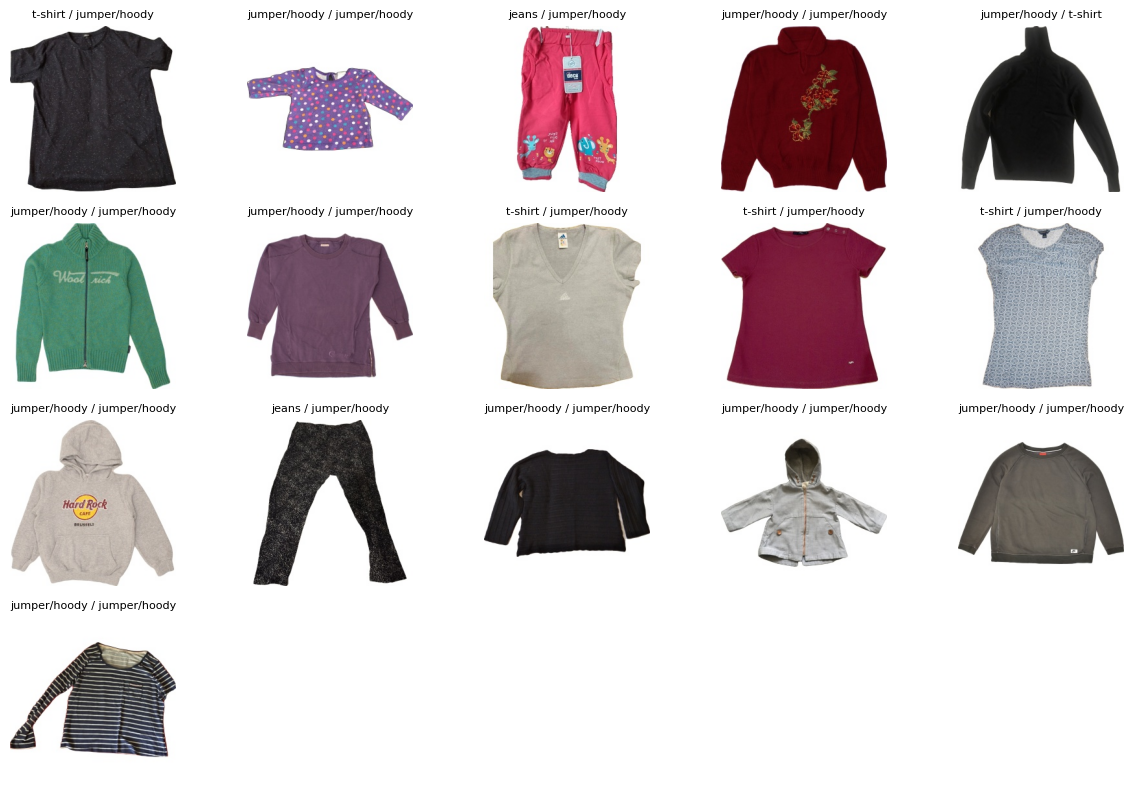

In [41]:
#Load trained model weights for evaluation and prediction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
 
model.eval()   # Set to evaluation mode

#Predict on a batch from the test set
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

#Visualize 16 predictions
import matplotlib.pyplot as plt

classes = ['t-shirt', 'jumper/hoody', 'jeans']
images_vis = images * 0.5 + 0.5   #Denormalize for viewing

fig = plt.figure(figsize=(12, 10))
for i in range(min(25, images.shape[0])):
    ax = fig.add_subplot(5, 5, i + 1)
    img = images_vis[i].permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    ax.set_title(f"{classes[labels[i]]} / {classes[preds[i]]}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

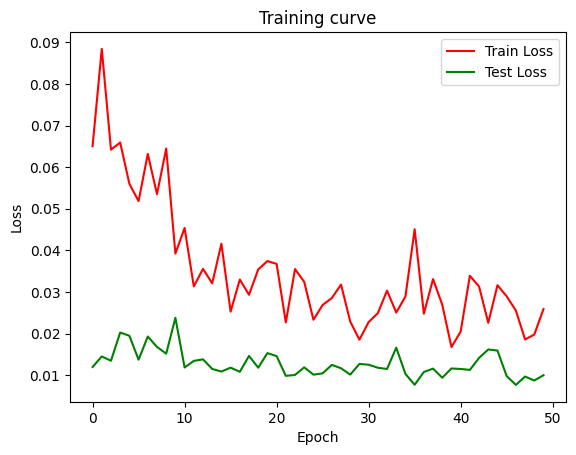

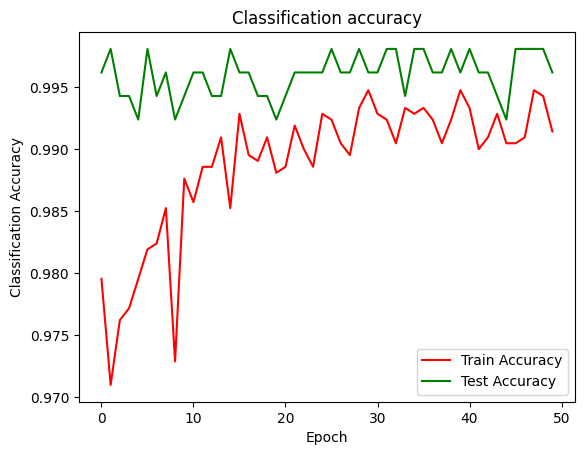

In [42]:
plt.title("Training curve")
plt.plot(range(len(training_losses)), training_losses, 'r', label='Train Loss')
plt.plot(range(len(testing_losses)), testing_losses, 'g', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("Classification accuracy")
plt.plot(range(len(training_accuracies)), training_accuracies, 'r', label='Train Accuracy')
plt.plot(range(len(testing_accuracies)), testing_accuracies, 'g', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.legend()
plt.show()

The loss curves show both training and test loss decreasing smoothly and staying close together, which means the model isn't overfitting.
The test accuracy is slightly higher than the training accuracy throughout most of the training. 

The test accuracy hovering around 0.985-0.990, while training accuracy is around 0.975-0.980. This shows that the model is generalizing better to unseen data than to the data it was trained on. This could be happen because the test set is slightly easier than the training set.

The key takeaway is that the model has learned the patterns effectively without memorizing the training data. The fact that both loss curves are decreasing together and the accuracies are so close (with test actually being a bit better) suggests this is a well-trained model that should perform reliably on new data.